# This is the NYC Taxi fare predictor 

<h2>Importing necessary Packages</h2>

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

<h1> Data Cleaning </h1>

As the Data set is too large we are taking the first One Million Entries.

In [27]:
df=pd.read_csv('C:\Dhruv Course Data\\train.csv',nrows=40000)

 <h1>1) Data Cleaning</h1>

A) We first calculate the Mean, Max, Min values.

In [28]:
df.describe()


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,11.349100,-72.509747,39.932891,-72.498153,39.920173,1.663300
std,9.634925,10.403879,6.315765,10.439964,6.065730,1.284104
min,-3.000000,-75.414728,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992060,40.734847,-73.991172,40.734332,1.000000
50%,8.500000,-73.981744,40.752705,-73.980199,40.753341,1.000000
75%,12.500000,-73.967090,40.767346,-73.963766,40.768155,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


<b>B) From the above data, we find the following anomalies- </b>
<br>
1) The minimum fare is- 44.9$ (Which is not possible)
</br><br>
2) Pickup & Dropoff Latitude and Longitude are beyond the normal range of -90 to +90 and -180 to +180 respectively.
</br>
<br>
3) The maximum passenger count is 208, which is not possible for a car.
</br>
<br>
3) A lot of data Values are equal to zero.
</br>

<br> <b>To remove these anomalies we first set the limits to the following values-</b> </br>
<br> 1) Max Passengers are limited to 6.</br>
<br> 2) Latitude and Longitude are limted to -90 to +90 and -180 to +180 respectively.</br>
<br> 3) Taking entries with fare >0 </br>
<br> 4) Removing Entries with all values=0 </br>



In [29]:
df_clean_1=df[df.passenger_count<=6] 
df_clean_1=df_clean_1[df_clean_1.pickup_longitude>=-180]
df_clean_1=df_clean_1[df_clean_1.pickup_longitude<=180]
df_clean_1=df_clean_1[df_clean_1.pickup_latitude>=-90]
df_clean_1=df_clean_1[df_clean_1.pickup_latitude<=90]
df_clean_1=df_clean_1[df_clean_1.pickup_latitude!=0]
df_clean_1=df_clean_1[df_clean_1.pickup_longitude!=0]
df_clean_1=df_clean_1[df_clean_1.dropoff_longitude>=-180]
df_clean_1=df_clean_1[df_clean_1.dropoff_longitude<=180]
df_clean_1=df_clean_1[df_clean_1.dropoff_latitude>=-90]
df_clean_1=df_clean_1[df_clean_1.dropoff_latitude<=90]
df_clean_1=df_clean_1[df_clean_1.fare_amount>0] 
df_clean_1=df_clean_1[df_clean_1.fare_amount<300] 
df_clean_1=df_clean_1[df_clean_1.dropoff_latitude!=0]
df_clean_1=df_clean_1[df_clean_1.dropoff_longitude!=0]
df_clean_1=df_clean_1[df_clean_1.pickup_longitude!=0]
df_clean_1=df_clean_1[df_clean_1.pickup_latitude!=0]
len(df_clean_1)

39197

<b>C) From the http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml NYC Taxi and Limousine Commision we get to know that the minimum taxi fare is 2.5$</b>

In [30]:
df_clean_1=df_clean_1[df_clean_1.fare_amount>=2.5]  
len(df_clean_1)

39196

<b>D) Further Points-</b>
  <br> 1) We also notice that the min pickup_longitude and pickup_latitude are -128.175,-121.39. Which even though not a pair but would correspond to pickups in the southern hemishphere which is an anomaly for a taxi.</br>
  <br>
   2) Similarly for the dropoff Longitude and Latitude. </br>
   
   <b> To solve this- </b>
    
   We limit the latitude and longitude to the rough boundries of places upto 215 miles from NYC. (Assuming cabs are generally travel less than 215 miles)
   <br>38.9<latitude<43
   <br>-76<longitude<-70
   
   

In [31]:
#Approx distance between one degree of longitude at New York is 53miles and distance in between latitude is 69
def longitude(df_clean_1):
    df_clean_1['abs_diff_longitude_miles'] = ((df_clean_1.dropoff_longitude - df_clean_1.pickup_longitude).abs())*53
    df_clean_1['abs_diff_latitude_miles'] = ((df_clean_1.dropoff_latitude - df_clean_1.pickup_latitude).abs())*69
    return  df_clean_1
df_clean_1=longitude(df_clean_1)
df_clean_1=df_clean_1[df_clean_1.pickup_latitude>=-38.9]
df_clean_1=df_clean_1[df_clean_1.pickup_latitude<=43]
df_clean_1=df_clean_1[df_clean_1.dropoff_longitude>=-76]
df_clean_1=df_clean_1[df_clean_1.dropoff_longitude<=-70]
df_clean_1=df_clean_1[df_clean_1.pickup_latitude>=-38.9]
df_clean_1=df_clean_1[df_clean_1.pickup_latitude<=43]
df_clean_1=df_clean_1[df_clean_1.dropoff_longitude>=-76]
df_clean_1=df_clean_1[df_clean_1.dropoff_longitude<=-70]
df_clean_1=df_clean_1[df_clean_1.abs_diff_longitude_miles<=130]
df_clean_1=df_clean_1[df_clean_1.abs_diff_latitude_miles<=130]
len(df_clean_1)

39169

<h1>2) Finding Correlations </h2>

In [32]:
def prepare_time(df):
    df['key'] = pd.to_datetime(df['key'])
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['pickup_day_of_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.weekday
    df['pickup_month'] = df['pickup_datetime'].dt.month
    df['pickup_date'] = df['pickup_datetime'].dt.day
    df['pickup_day_of_week_name'] = df['pickup_datetime'].dt.weekday_name
    df['pickup_year'] = df['pickup_datetime'].dt.year
    return df

df_clean_1=prepare_time(df_clean_1)
df_clean_1

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude_miles,abs_diff_latitude_miles,pickup_day_of_hour,pickup_day_of_week,pickup_month,pickup_date,pickup_day_of_week_name,pickup_year
0,2009-06-15 17:26:21.000000100,4.50,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,0.143153,0.623829,17,0,6,15,Monday,2009
1,2010-01-05 16:52:16.000000200,16.90,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,1.949340,4.878369,16,1,1,5,Tuesday,2010
2,2011-08-18 00:35:00.000000490,5.70,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0.450712,0.738852,0,3,8,18,Thursday,2011
3,2012-04-21 04:30:42.000000100,7.70,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,0.235161,1.721481,4,5,4,21,Saturday,2012
4,2010-03-09 07:51:00.000000135,5.30,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,0.606320,1.087026,7,1,3,9,Tuesday,2010
5,2011-01-06 09:50:45.000000200,12.10,2011-01-06 09:50:45,-74.000964,40.731630,-73.972892,40.758233,1,1.487816,1.835607,9,3,1,6,Thursday,2011
6,2012-11-20 20:35:00.000000100,7.50,2012-11-20 20:35:00,-73.980002,40.751662,-73.973802,40.764842,1,0.328600,0.909420,20,1,11,20,Tuesday,2012
7,2012-01-04 17:22:00.000000810,16.50,2012-01-04 17:22:00,-73.951300,40.774138,-73.990095,40.751048,1,2.056135,1.593210,17,2,1,4,Wednesday,2012
8,2012-12-03 13:10:00.000000125,9.00,2012-12-03 13:10:00,-74.006462,40.726713,-73.993078,40.731628,1,0.709352,0.339135,13,0,12,3,Monday,2012
9,2009-09-02 01:11:00.000000830,8.90,2009-09-02 01:11:00,-73.980658,40.733873,-73.991540,40.758138,2,0.576746,1.674285,1,2,9,2,Wednesday,2009


In [33]:
def EucledianDistanceTaxiFare(df):
    df['EucledianDistance'] = np.sqrt(np.power(df['abs_diff_longitude_miles'],2)+np.power(df['abs_diff_latitude_miles'],2))
    return df;
df_clean_1=EucledianDistanceTaxiFare(df_clean_1)
#corr = df_clean_1.corr(method='pearson')
#print corr

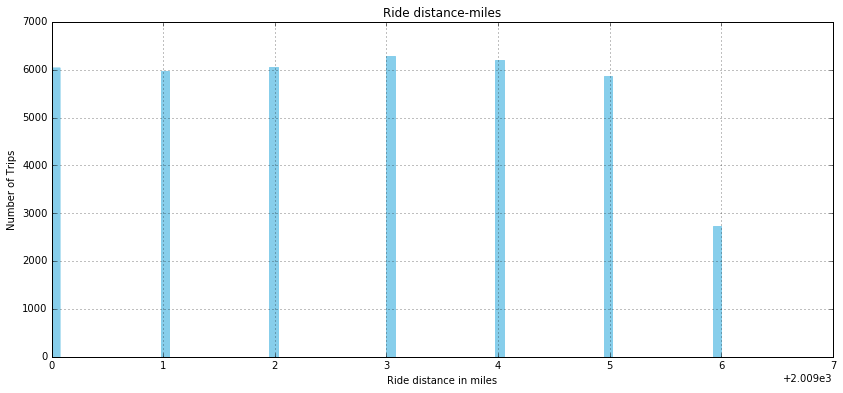

In [34]:
#There are no rides greater than 40 miles in the cleaned data set.
tmp=df_clean_1
tmp['pickup_year'].hist(bins=80, figsize=(14,6),color = "skyblue", ec="skyblue")
plt.xlabel('Ride distance in miles')
plt.ylabel('Number of Trips')
plt.title('Ride distance-miles')


In [35]:
df_clean_1.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude_miles,abs_diff_latitude_miles,pickup_day_of_hour,pickup_day_of_week,pickup_month,pickup_date,pickup_year,EucledianDistance
count,39169.000000,39169.000000,39169.000000,39169.000000,39169.000000,39169.000000,39169.000000,39169.000000,39169.000000,39169.000000,39169.000000,39169.000000,39169.000000,39169.000000
mean,11.341876,-73.975100,40.750909,-73.974059,40.751334,1.665092,1.221685,1.495455,13.481018,3.035819,6.269729,15.683142,2011.745666,2.108553
std,9.590514,0.040580,0.035064,0.039073,0.036228,1.285075,1.924363,2.007788,6.513141,1.957451,3.457733,8.676648,1.863570,2.649014
min,2.500000,-75.414728,39.603178,-75.354559,39.604972,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2009.000000,0.000000
25%,6.000000,-73.992300,40.736508,-73.991362,40.735858,1.000000,0.324360,0.479895,9.000000,1.000000,3.000000,8.000000,2010.000000,0.789258
50%,8.500000,-73.982050,40.753458,-73.980612,40.754060,1.000000,0.679990,0.981939,14.000000,3.000000,6.000000,16.000000,2012.000000,1.349659
75%,12.500000,-73.968323,40.767755,-73.965532,40.768473,2.000000,1.281006,1.883562,19.000000,5.000000,9.000000,23.000000,2013.000000,2.448321
max,200.000000,-72.856968,42.160275,-72.854940,42.168717,6.000000,46.316647,80.638420,23.000000,6.000000,12.000000,31.000000,2015.000000,80.638421


In [13]:
plt.plot(df_clean_1["EucledianDistance"][:,-1], 'go-', label="Data points")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ValueError: Can only tuple-index with a MultiIndex

In [ ]:
df_clean_1['EucledianDistance'].plot(kind='bar')

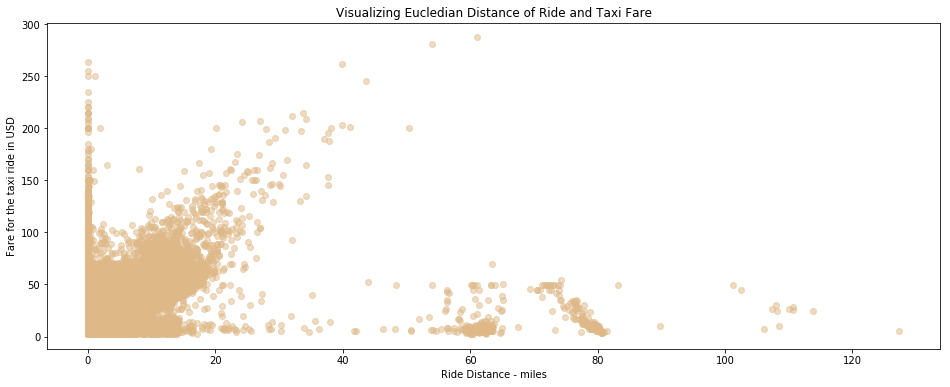

In [10]:
fig, axs = plt.subplots(figsize=(16,6))
axs.set_title('Visualizing Eucledian Distance of Ride and Taxi Fare')
axs.set_xlabel('Ride Distance - miles')
axs.set_ylabel('Fare for the taxi ride in USD')
axs.scatter(tmp.EucledianDistance, tmp.fare_amount, alpha=0.5,color = "burlywood")

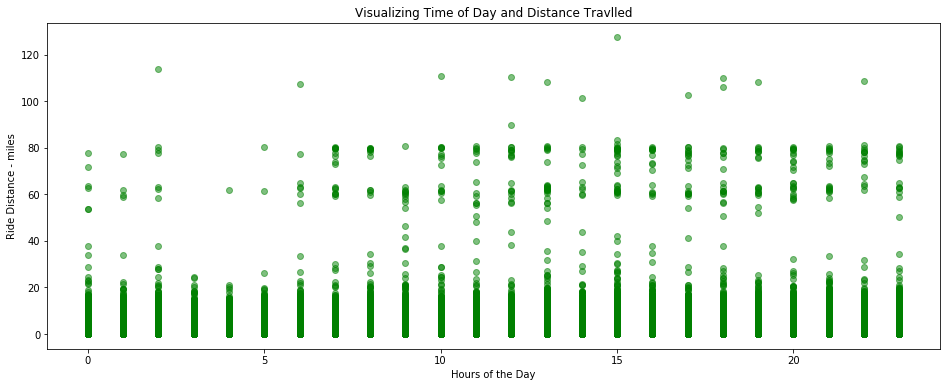

In [11]:
fig, axs = plt.subplots(figsize=(16,6))
axs.set_title('Visualizing Time of Day and Distance Travlled')
axs.set_xlabel('Hours of the Day')
axs.set_ylabel('Ride Distance - miles')
axs.scatter(tmp.pickup_day_of_hour, tmp.EucledianDistance, alpha=0.5,color = "green")

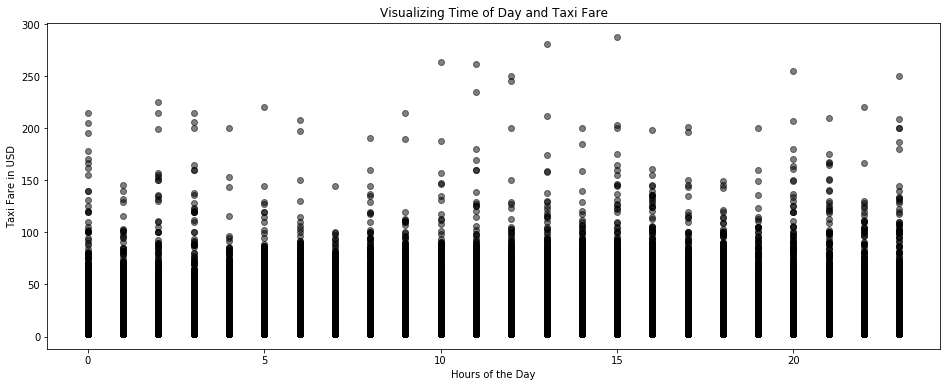

In [12]:
fig, axs = plt.subplots(figsize=(16,6))
axs.set_title('Visualizing Time of Day and Taxi Fare')
axs.set_xlabel('Hours of the Day')
axs.set_ylabel('Taxi Fare in USD')
axs.scatter(tmp.pickup_day_of_hour, tmp.fare_amount, alpha=0.5,color = "black")

 # 4) Plot of our own

In [13]:
tmp_Inde=df_clean_1[df_clean_1.pickup_month==7]
tmp_Inde=df_clean_1[df_clean_1.pickup_date==4]
tmp_chris=df_clean_1[df_clean_1.pickup_month==12]
tmp_chris=df_clean_1[df_clean_1.pickup_date==25]
tmp_NY=df_clean_1[(df_clean_1.pickup_month==1) | (df_clean_1.pickup_month==12)]
tmp_NY=df_clean_1[(df_clean_1.pickup_date==1)|(df_clean_1.pickup_date==31)]
tmp_NY=df_clean_1[(df_clean_1.pickup_day_of_hour<7)]
tmp_weekend= df_clean_1[(df_clean_1.pickup_day_of_week_name=='Saturday') | (df_clean_1.pickup_day_of_week_name=='Sunday')]
tmp_weekday=df_clean_1[(df_clean_1.pickup_day_of_week_name=='Monday') | (df_clean_1.pickup_day_of_week_name=='Tuesday')| (df_clean_1.pickup_day_of_week_name=='Wednesday')| (df_clean_1.pickup_day_of_week_name=='Thurday')| (df_clean_1.pickup_day_of_week_name=='Friday')]

In [14]:
data_holiday = [['Christmas',tmp_chris['fare_amount'].mean()],['New Year',tmp_NY['fare_amount'].mean()],['Independence Day',tmp_Inde['fare_amount'].mean()],['Year Average',df_clean_1['fare_amount'].mean()]]
df_holidays=pd.DataFrame(data_holiday,columns=['Holiday','AverageFare'])
data_workdays = [['Weekday',tmp_weekend['fare_amount'].mean()],['Weekend',tmp_weekday['fare_amount'].mean()]]
df_workdays=pd.DataFrame(data_workdays,columns=['Weekdays','AverageFare'])

<BarContainer object of 4 artists>

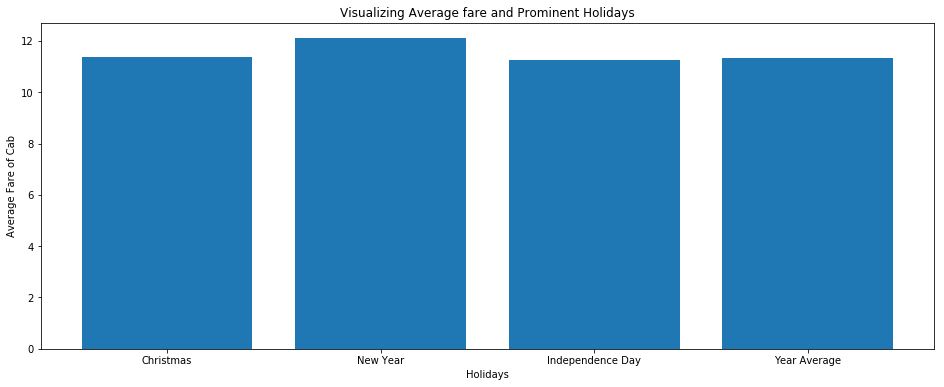

In [15]:
fig, axs = plt.subplots(figsize=(16,6))
axs.set_title('Visualizing Average fare and Prominent Holidays')
axs.set_xlabel('Holidays')
axs.set_ylabel('Average Fare of Cab')
axs.bar(['Christmas','New Year','Independence Day', 'Year Average'], height=[df_holidays.AverageFare[0],df_holidays.AverageFare[1],df_holidays.AverageFare[2],df_holidays.AverageFare[3]])




<BarContainer object of 2 artists>

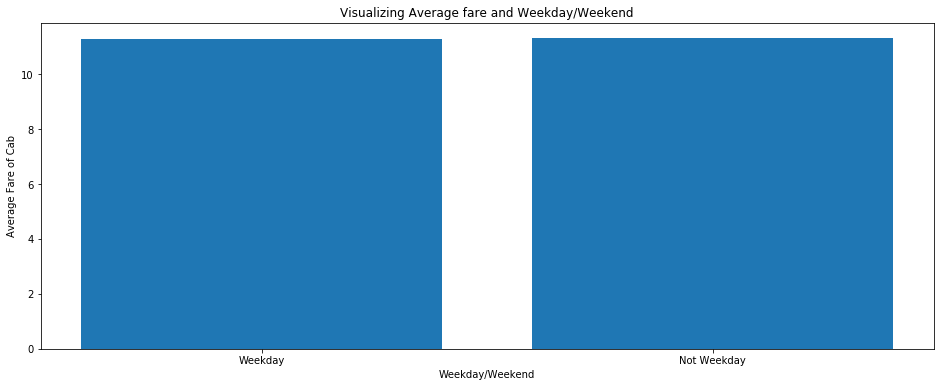

In [16]:
fig, axs = plt.subplots(figsize=(16,6))
axs.set_title('Visualizing Average fare and Weekday/Weekend')
axs.set_xlabel('Weekday/Weekend')
axs.set_ylabel('Average Fare of Cab')
axs.bar(['Weekday','Not Weekday'], height=[df_workdays.AverageFare[0],df_workdays.AverageFare[1]])



# NOTE: There are a few more plots created after point 8.

# 5) Generating new feature set

In [ ]:
# Adding approximate commute time
def commute_time(df):
    df['commute_time'] = 0.5*((df['fare_amount']/0.4)-(df['EucledianDistance']/5))
    return df

df_clean_1=commute_time(df_clean_1)
df_clean_1.head()                           
                              

In [ ]:
def average_speed(df):
    df['average_speed'] = df['EucledianDistance']/(df['commute_time']/60)
    return df

df_clean_1=average_speed(df_clean_1)
df_clean_1.head()

In [ ]:
def time_day(df_clean_1):
        df_clean_1['time_day']=np.where(((df_clean_1.pickup_day_of_hour>=20)|(df_clean_1.pickup_day_of_hour<=6)),0,1)
        return df_clean_1
def airport(df_clean_1):
        df_clean_1['airport']=np.where((((df_clean_1.pickup_latitude>40.62)&(df_clean_1.pickup_latitude<40.66))&((df_clean_1.pickup_longitude>-73.82)&(df_clean_1.pickup_longitude<-73.74))|((df_clean_1.pickup_latitude>40.76)&(df_clean_1.pickup_latitude<40.78))&((df_clean_1.pickup_longitude>-73.88)&(df_clean_1.pickup_longitude<-73.85))|((df_clean_1.pickup_latitude>40.66)&(df_clean_1.pickup_latitude<40.72))&((df_clean_1.pickup_longitude>-74.20)&(df_clean_1.pickup_longitude<-74.129))),1,0)
        return df_clean_1

# 6) Setting up a simple Linear Regression Model

In [20]:
df_x=df_clean_1.drop(['key', 'pickup_datetime','fare_amount','pickup_day_of_week_name','commute_time','average_speed'], axis=1)
df_y=df_clean_1.fare_amount
df_x=time_day(df_x)
df_x=airport(df_x)
linreg=linear_model.LinearRegression()
linreg.fit(df_x,df_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
linreg.coef_

array([-1.15165378e+01, -1.14384153e+00,  2.00893179e+01, -1.10049725e+01,
        5.09875838e-02,  1.95049296e+00,  8.04838726e-01, -3.14314670e-03,
       -5.12634480e-04,  8.26434666e-02,  2.27925602e-03,  5.39586391e-01,
        7.12490840e-01,  5.10498764e-01,  9.72522803e+00])

In [22]:
df_x.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude_miles,abs_diff_latitude_miles,pickup_day_of_hour,pickup_day_of_week,pickup_month,pickup_date,pickup_year,EucledianDistance,time_day,airport
0,-73.844311,40.721319,-73.841610,40.712278,1,0.143153,0.623829,17,0,6,15,2009,0.640043,1,0
1,-74.016048,40.711303,-73.979268,40.782004,1,1.949340,4.878369,16,1,1,5,2010,5.253419,1,0
2,-73.982738,40.761270,-73.991242,40.750562,2,0.450712,0.738852,0,3,8,18,2011,0.865473,0,0
3,-73.987130,40.733143,-73.991567,40.758092,1,0.235161,1.721481,4,5,4,21,2012,1.737469,0,0
4,-73.968095,40.768008,-73.956655,40.783762,1,0.606320,1.087026,7,1,3,9,2010,1.244689,1,0


In [23]:
df_test=pd.read_csv('C:\Dhruv Course Data\\test.csv')

In [24]:
df_test=longitude(df_test)
df_test=prepare_time(df_test)
df_test=EucledianDistanceTaxiFare(df_test)
df_test=time_day(df_test)
df_test=airport(df_test)
df_test=df_test.drop(['key', 'pickup_datetime','pickup_day_of_week_name'], axis=1)
df_test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude_miles,abs_diff_latitude_miles,pickup_day_of_hour,pickup_day_of_week,pickup_month,pickup_date,pickup_year,EucledianDistance,time_day,airport
0,-73.973320,40.763805,-73.981430,40.743835,1,0.429832,1.377926,13,1,1,27,2015,1.443411,1,0
1,-73.986862,40.719383,-73.998886,40.739201,1,0.637268,1.367397,13,1,1,27,2015,1.508604,1,0
2,-73.982524,40.751260,-73.979654,40.746139,1,0.152110,0.353349,11,5,10,8,2011,0.384699,1,0
3,-73.981160,40.767807,-73.990448,40.751635,1,0.492264,1.115868,21,5,12,1,2012,1.219625,0,0
4,-73.966046,40.789775,-73.988565,40.744427,1,1.193507,3.129012,21,5,12,1,2012,3.348907,0,0


In [25]:
a=linreg.predict(df_test)

In [26]:
for i in linreg.coef_:
    print i

-11.516537833992492
-1.143841531108411
20.08931794150554
-11.004972524150086
0.050987583777515305
1.9504929614260893
0.8048387259684119
-0.003143146697975667
-0.0005126344804598278
0.08264346656976797
0.002279256022140269
0.5395863910616406
0.7124908400634912
0.5104987639267443
9.725228028540672


In [27]:
df_key=pd.read_csv('C:\Dhruv Course Data\\test.csv')
submission = pd.DataFrame(columns=['key','fare_amount'])
submission.key=df_key.key
submission.fare_amount=a
submission.to_csv('submission_linreg.csv', index = False)

<h1>7) Using External Data Set</h1> <br>
(a)The weather of the the city of New York on that day could help in predicting if rain and snow days effect taxi fares.<br>
(b)The introduction of Uber and Lyft.<br>
(c)The office hours of companies.<br>
(d)Suspension of subway lines for repairs.

In [28]:
df_crime=pd.read_csv('C:\Users\kelad\Downloads\crimes-new-york-city\NYPD_Complaint_Data_Historic.csv')

C:\Users\kelad\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
def add_crime_data(df,data):
    df=df[df.Latitude>=-38.9]
    df=df[df.Latitude<=43]
    df=df[df.Longitude>=-76]
    df=df[df.Longitude<=-70]
    df = df[np.isfinite(df['Latitude'])]
    df = df[np.isfinite(df['Longitude'])]
    df['ConvertedLatitude']=(df['Latitude']*10000)
    df['ConvertedLongitude']=(df['Longitude']*10000)
    df['ConvertedLatitude'] = df['ConvertedLatitude'].astype(int)
    df['ConvertedLongitude'] = df['ConvertedLongitude'].astype(int)
    data['ConvertedLatitude']=(data['pickup_latitude']*10000)
    data['ConvertedLongitude']=(data['pickup_longitude']*10000)
    data['ConvertedLatitude'] = data['ConvertedLatitude'].astype(int)
    data['ConvertedLongitude'] = data['ConvertedLongitude'].astype(int)    
    l1=df['ConvertedLongitude'].tolist()
    l2=df['ConvertedLatitude'].tolist()
    t1=data['ConvertedLongitude'].isin(l1)
    t2=data['ConvertedLatitude'].isin(l1)
    t1=pd.Series(t1)
    t2=pd.Series(t2)
    data['crime']=t1
    return data
df_clean_1=add_crime_data(df_crime,df_clean_1)

# 8) Better Prediction Model

In [ ]:
#df_clean_1=df_clean_1[(df_clean_1.EucledianDistance<10)&(df_clean_1.fare_amount>100)]
chk=time_day(df_clean_1)
chk=airport(df_clean_1)

In [31]:
len(chk[chk.airport==1])

33818

In [32]:
chk.corr(method='pearson')

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude_miles,abs_diff_latitude_miles,pickup_day_of_hour,pickup_day_of_week,...,pickup_date,pickup_year,EucledianDistance,commute_time,average_speed,ConvertedLatitude,ConvertedLongitude,crime,time_day,airport
fare_amount,1.000000,0.342889,-0.167925,0.263273,-0.140677,0.014199,0.743102,0.572863,-0.019220,0.002509,...,0.001450,0.116807,0.754946,0.999900,0.011627,-0.167924,0.342886,-0.043292,-0.016095,0.487743
pickup_longitude,0.342889,1.000000,0.142903,0.458642,0.147233,0.000191,0.370813,0.220855,0.016015,-0.021373,...,-0.000620,0.002755,0.323848,0.341449,0.015142,0.142907,1.000000,-0.177686,0.040478,0.636910
pickup_latitude,-0.167925,0.142903,1.000000,0.171180,0.512019,-0.006186,-0.132356,-0.177085,0.024123,-0.033058,...,-0.000938,-0.015750,-0.185071,-0.166648,-0.023064,1.000000,0.142909,-0.172792,0.096235,-0.196820
dropoff_longitude,0.263273,0.458642,0.171180,1.000000,0.228016,-0.001451,0.292718,0.158364,-0.037808,-0.001170,...,0.001382,-0.000176,0.253695,0.262059,0.000198,0.171182,0.458644,-0.145938,-0.024412,0.124798
dropoff_latitude,-0.140677,0.147233,0.512019,0.228016,1.000000,-0.003659,-0.109357,-0.157052,0.016141,-0.026133,...,-0.000009,-0.008397,-0.165184,-0.139388,0.000357,0.512020,0.147237,-0.097277,0.067748,-0.061423
passenger_count,0.014199,0.000191,-0.006186,-0.001451,-0.003659,1.000000,0.007982,0.005902,0.016920,0.036511,...,0.004113,0.005922,0.007755,0.014262,-0.001706,-0.006188,0.000192,0.003148,-0.021932,0.008426
abs_diff_longitude_miles,0.743102,0.370813,-0.132356,0.292718,-0.109357,0.007982,1.000000,0.508590,-0.026448,0.000680,...,0.001178,0.020137,0.858010,0.736607,0.052811,-0.132353,0.370812,-0.129639,-0.028602,0.507270
abs_diff_latitude_miles,0.572863,0.220855,-0.177085,0.158364,-0.157052,0.005902,0.508590,1.000000,-0.018758,0.019527,...,0.000374,0.008412,0.863640,0.563485,0.062411,-0.177084,0.220856,-0.083204,-0.080494,0.240970
pickup_day_of_hour,-0.019220,0.016015,0.024123,-0.037808,0.016141,0.016920,-0.026448,-0.018758,1.000000,-0.087953,...,0.001923,0.002243,-0.026488,-0.018960,-0.001202,0.024123,0.016014,-0.000181,-0.027174,0.035634
pickup_day_of_week,0.002509,-0.021373,-0.033058,-0.001170,-0.026133,0.036511,0.000680,0.019527,-0.087953,1.000000,...,0.007208,0.008908,0.011895,0.002292,0.000804,-0.033057,-0.021373,0.002293,-0.100727,-0.020256


In [ ]:
df_x=chk.drop(['key', 'pickup_datetime','fare_amount','pickup_day_of_week_name','commute_time','average_speed'], axis=1)
df_y=chk.fare_amount

In [ ]:
rf = RandomForestRegressor()
rf.fit(df_x, df_y)

In [ ]:
df_test=pd.read_csv('C:\Dhruv Course Data\\test.csv')
df_test=longitude(df_test)
df_test=prepare_time(df_test)
df_test=EucledianDistanceTaxiFare(df_test)
df_test=time_day(df_test)
df_test=airport(df_test)
#df_test=add_crime_data(df_crime,df_test)
df_test=df_test.drop(['key', 'pickup_datetime','pickup_day_of_week_name'], axis=1)

In [ ]:
a = rf.predict(df_test)
df_key=pd.read_csv('C:\Dhruv Course Data\\test.csv')
submission = pd.DataFrame(columns=['key','fare_amount'])
submission.key=df_key.key
submission.fare_amount=a
submission.to_csv('submission_rf.csv', index = False)

In [37]:
knr=KNeighborsRegressor()
knr.fit(df_x, df_y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [38]:
a = knr.predict(df_test)
df_key=pd.read_csv('C:\Dhruv Course Data\\test.csv')
submission = pd.DataFrame(columns=['key','fare_amount'])
submission.key=df_key.key
submission.fare_amount=a
submission.to_csv('submission_knr.csv', index = False)

# Extra Model Graphs

In [39]:
tmp_air=df_clean_1[chk.airport==1]
tmp_nair=df_clean_1[chk.airport==0]

In [40]:
tmp_a = [['AirportFare',tmp_air['fare_amount'].mean()],['NotAirportFare',tmp_nair['fare_amount'].mean()]]
df_a=pd.DataFrame(tmp_a,columns=['Pickup','fare'])

<BarContainer object of 2 artists>

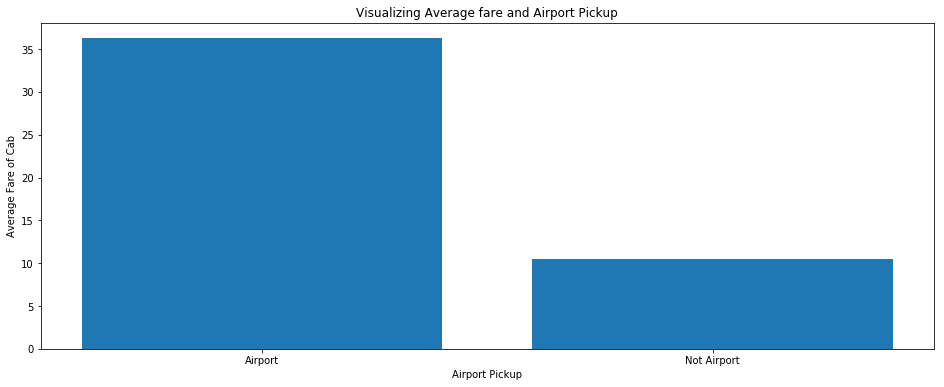

In [41]:
fig, axs = plt.subplots(figsize=(16,6))
axs.set_title('Visualizing Average fare and Airport Pickup')
axs.set_xlabel('Airport Pickup')
axs.set_ylabel('Average Fare of Cab')
#axs.hist(y=df_a.fare)
axs.bar(['Airport','Not Airport'], height=[df_a.fare[0],df_a.fare[1]])




In [42]:
tmp_mor=df_clean_1[chk.time_day==1]
tmp_nmor=df_clean_1[chk.time_day==0]
tmp_b = [['AirportFare',tmp_mor['fare_amount'].mean()],['NotAirportFare',tmp_nmor['fare_amount'].mean()]]
df_b=pd.DataFrame(tmp_b,columns=['Time','fare'])




<BarContainer object of 2 artists>

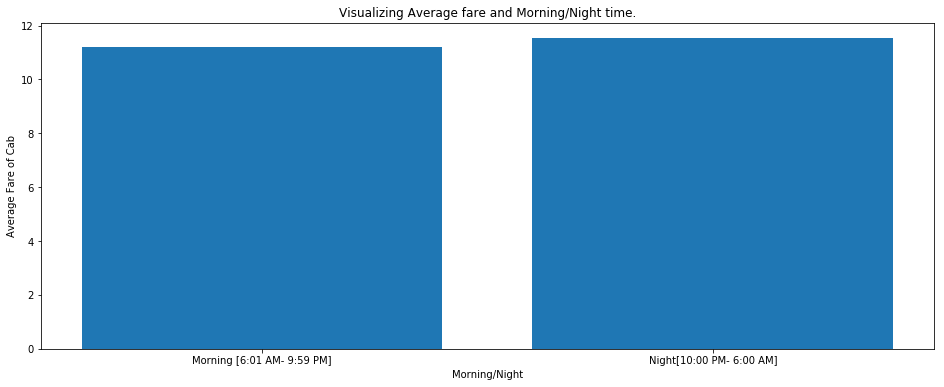

In [43]:
fig, axs = plt.subplots(figsize=(16,6))
axs.set_title('Visualizing Average fare and Morning/Night time.')
axs.set_xlabel('Morning/Night')
axs.set_ylabel('Average Fare of Cab')
#axs.hist(y=df_a.fare)
axs.bar(['Morning [6:01 AM- 9:59 PM]','Night[10:00 PM- 6:00 AM]'], height=[df_b.fare[0],df_b.fare[1]])

In [13]:
df_clean_1.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude_miles,abs_diff_latitude_miles,pickup_day_of_hour,pickup_day_of_week,pickup_month,pickup_date,pickup_day_of_week_name,pickup_year,EucledianDistance
0,2009-06-15 17:26:21.000000100,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,0.143153,0.623829,17,0,6,15,Monday,2009,0.640043
1,2010-01-05 16:52:16.000000200,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,1.949340,4.878369,16,1,1,5,Tuesday,2010,5.253419
2,2011-08-18 00:35:00.000000490,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0.450712,0.738852,0,3,8,18,Thursday,2011,0.865473
3,2012-04-21 04:30:42.000000100,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,0.235161,1.721481,4,5,4,21,Saturday,2012,1.737469
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,0.606320,1.087026,7,1,3,9,Tuesday,2010,1.244689


In [50]:
df=df_clean_1.filter(['EucledianDistance','pickup_year'], axis=1)
df1=df_clean_1.filter([], axis=1)

In [40]:
df.head()

,EucledianDistance,pickup_year
0,0.640043,2009
1,5.253419,2010
2,0.865473,2011
3,1.737469,2012
4,1.244689,2010


In [41]:
df['pickup_year'].unique()

array([2009, 2010, 2011, 2012, 2013, 2014, 2015], dtype=int64)

In [42]:
df.groupby('pickup_year')['EucledianDistance'].sum()

pickup_year
2009    7881.405657
2010    7608.636229
2011    8348.013684
2012    8377.598036
2013    8036.061387
2014    7825.174405
2015    3672.398435
Name: EucledianDistance, dtype: float64

In [63]:
data = [[2009,7881.405657],[2010,7608.636229],[2011,8348.013684],[2012,8506.598036],[2013,8734.546],[2014,8832.174405],[2015,8734.34805],[2016,8943.174405],[2017,9234.9034],[2018,9453.3422]]
df = pd.DataFrame(data,columns=['Year','Distance'])

In [64]:
print df

   Year     Distance
0  2009  7881.405657
1  2010  7608.636229
2  2011  8348.013684
3  2012  8506.598036
4  2013  8734.546000
5  2014  8832.174405
6  2015  8734.348050
7  2016  8943.174405
8  2017  9234.903400
9  2018  9453.342200


<BarContainer object of 10 artists>

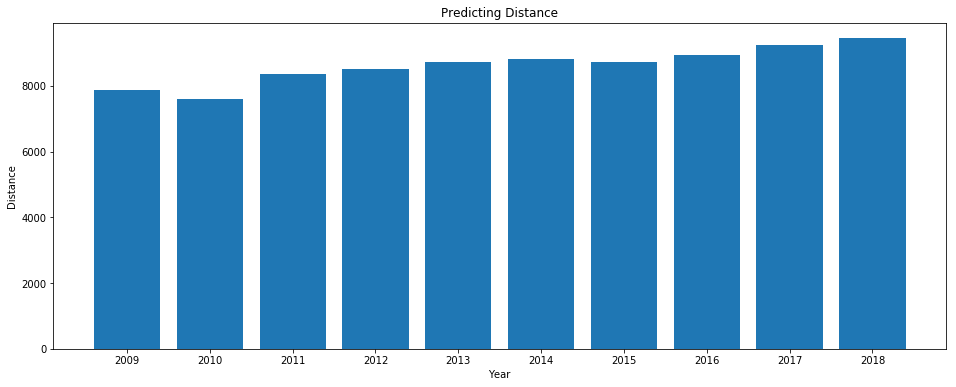

In [67]:
fig, axs = plt.subplots(figsize=(16,6))
axs.set_title('Predicting Distance')
axs.set_xlabel('Year')
axs.set_ylabel('Distance')
#axs.hist(y=df_a.fare)
axs.bar(['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018'], height=[df.Distance[0],df.Distance[1],df.Distance[2],df.Distance[3],df.Distance[4],df.Distance[5],df.Distance[6],df.Distance[7],df.Distance[8],df.Distance[9]])